# ARIMA

**Assumptions:**
- Stationary time series
    - If it's not do differences until it is

In [258]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf

import itertools # using the product for the cartesian product
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

### Object

In [253]:
# essentially https://goldinlocks.github.io/Time-Series-Cross-Validation/
class BlockingTimeSeriesSplit:
    def __init__(self, n_splits: int = 5, val_size: float = 0.2):
        self.n_splits = n_splits
        self.val_size = val_size

    def split(self, X, y=None):
        block_size = len(X) // self.n_splits
        indices = np.arange(len(X))
        for i in range(self.n_splits):
            start = i * block_size
            stop = start + block_size
            split = stop - int(self.val_size * (stop-start))
            yield indices[start:split], indices[split:stop]

### Helper Functions

In [146]:
def plot_forecasts(df: pd.DataFrame, pred: pd.Series, s: int):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df.date,
        y=df.consumption,
        mode='lines',
        name='Actual'
    ))
    
    fig.add_trace(go.Scatter(
        x=df.loc[s:, 'date'],
        y=pred,
        mode='lines',
        name='Forecasted'
    ))
    
    fig.update_layout(
        title="Actual vs Forecasted Values for Consumption",
        xaxis_title="Date",
        yaxis_title="Consumption (MWh)",
        legend_title="Legend"
    )
    fig.show()

In [207]:
def create_corr_plot(series, lags=None, plot_pacf=False):
    # from https://community.plotly.com/t/plot-pacf-plot-acf-autocorrelation-plot-and-lag-plot/24108/3
    corr_array = pacf(series.dropna(), nlags=lags, alpha=0.05) if plot_pacf else acf(series.dropna(), nlags=lags, alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=8)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_yaxes(zerolinecolor='#000000', range=[-1, 1])
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show()

In [208]:
def plot_forecast_cv():
    pass

## Prepare the Data

Due to us using demand as a proxy for consumption it will have to be dropped as a feature.

Everything else will either have to be dropped if there is less that 90% non-nan values. Everything else will be backward filled and forward filled.

In [209]:
data = pd.read_csv("../../../data/dataset.csv", parse_dates=['date'])
thresh = int(0.9 * len(data))
data = data.dropna(axis=1, thresh=thresh).bfill().ffill().drop('demand', axis=1)
# data

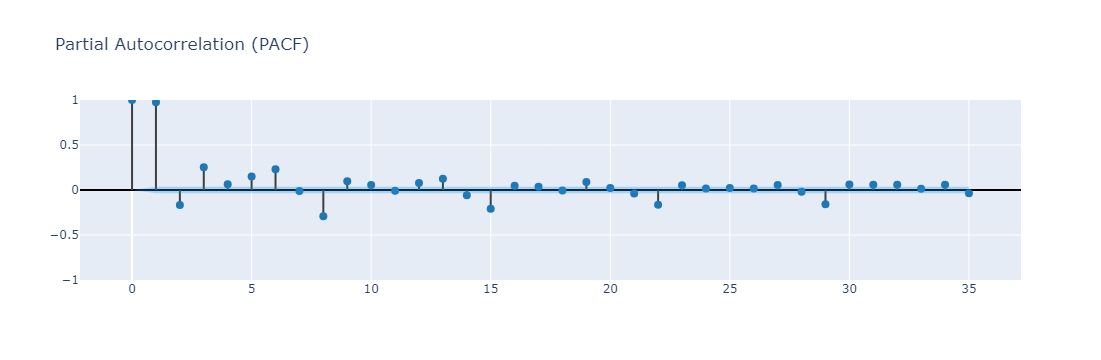

In [212]:
create_corr_plot(data.consumption, None, True)

## Splits

In [149]:
data.shape

(3184, 23)

In [150]:
data.date.min(), data.date.max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2024-09-18 00:00:00'))

In [151]:
split = int(len(data) * 0.85)
train, test = data.iloc[:split, :], data.iloc[split:, :]
endog_train, exog_train = train['consumption'], train.drop(['date', 'consumption'], axis=1)
endog_test, exog_test = test['consumption'], test.drop(['date', 'consumption'], axis=1)

## Training a Baseline

In [153]:
order = (0, 1, 0)
seasonal_order = (0, 0, 0, 0)
baseline = SARIMAX(endog_train, exog_train.astype(float), order=order, seasonal_order=seasonal_order).fit(method='bfgs')

Optimization terminated successfully.
         Current function value: 12.837448
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


In [154]:
predictions = baseline.forecast(steps=len(endog_test), exog=exog_test)

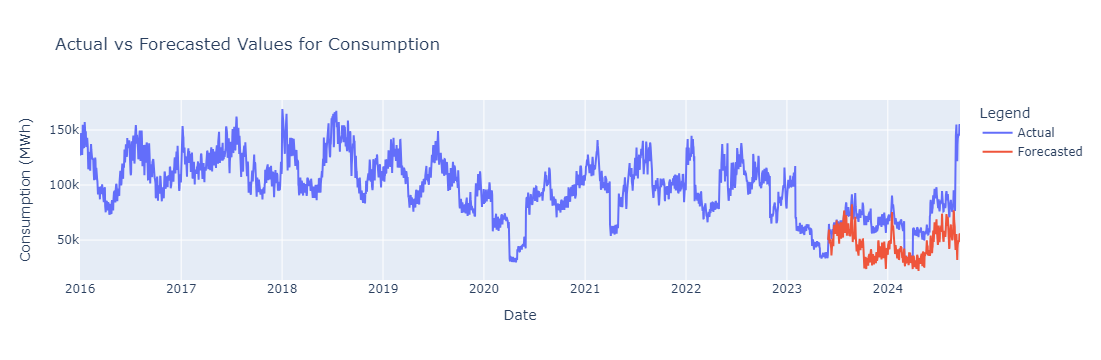

In [155]:
plot_forecasts(data, predictions, split)

In [160]:
baseline.save("../../models/SARIMAX_baseline.pickle")

## Hyper-Parameter Tuning and Cross Validation

SKlearn can't really help us here so how will we do cross validation?

Cross validation in Sklearn is using the k-1 folds for training and a hold out set, we are using blocked CV, so we will be averaging our holdout in each CV (the future for each CV). There will be no overlapping between blocks so we don't worry about that. We have an untouched test set which we will see at the end when we compare our top 3 SARIMAX models. For comparability I think mean squared error is the best choice.

In [264]:
btss = BlockingTimeSeriesSplit(n_splits=4, val_size=0.2)
p = range(0, 4)
q = range(0, 4)
d = range(0, 4)
orders = itertools.product(p, q, d)

P = range(0, 4)
Q = range(0, 4)
D = range(0, 4)
s = range(0, 4)
seasonal_orders = itertools.product(P, Q, D, s)

for ods, sam in itertools.product(orders, seasonal_orders):
    for i, (x, y) in enumerate(btss.split(train)):
        endog_train, exog_train = train.loc[x, 'consumption'], train.loc[x].drop(['date', 'consumption'], axis=1)
        endog_val, exog_val = train.loc[y, 'consumption'], train.loc[y].drop(['date', 'consumption'], axis=1)

        model = SARIMAX(endog_train, exog_train.astype(float), order=order, seasonal_order=seasonal_order).fit(method='bfgs')
        predictions = model..forecast(steps=len(endog_val), exog=exog_val)

KeyboardInterrupt: 

## Evaluation